In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

### 1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

In [48]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

n_trees_list = [1, 3, 10, 50, 70, 100]

In [26]:
np.random.seed(42)

def get_bootstrap(data, labels, n):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(n):
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_lables = labels[sample_index]
        
        bootstrap.append((b_data, b_lables))
    
    return bootstrap


In [27]:
def get_subsample(len_sample):
    sample_indexes = list(range(len_sample))
    
    len_subsample = int(np.sqrt(len_sample))
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)
    
    return subsample

In [28]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch

In [29]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
    
    def predict(self):
        classes = {}
        
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            
            classes[label] += 1
        
        prediction = max(classes, key=classes.get)
        return prediction

In [30]:
def gini(labels):
    classes = {}
    
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [31]:
def gain(left_labels, right_labels, root_gini):
    
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [32]:
def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [33]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [34]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [35]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [36]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [37]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [38]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
#     print(predictions, type(predictions))

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
#     print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [39]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [40]:
def get_meshgrid(data, step=0.5, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [41]:
def visualize(train_data, train_labels, test_data, test_labels, n_trees, train_accuracy, test_accuracy, forest):
    
    plt.figure(figsize=(16, 7))
    
    plt.subplot(1, 2, 1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, cmap=colors)
    plt.title(f'Train accuracy = {train_accuracy}, Trees count = {n_trees}')
    
    plt.subplot(1, 2, 2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels, cmap=colors)
    plt.title(f'Test accuracy = {test_accuracy}, Trees count = {n_trees}')

In [42]:
def ans(data, labels, n_trees_list):
    train_data, test_data, train_labels, test_labels = train_test_split(data, 
                                                                        labels, 
                                                                        test_size=0.3, 
                                                                        random_state=1)
    accuracies = []
    data = [train_data, train_labels, test_data, test_labels]
    for n_trees in n_trees_list:
        trees = random_forest(train_data, train_labels, n_trees)
        
        train_answers = tree_vote(trees, train_data)
        test_answers = tree_vote(trees, test_data)
        
        train_accuracy = accuracy_metric(train_labels, train_answers)
        test_accuracy = accuracy_metric(test_labels, test_answers)
        
        accuracies.append((n_trees, train_accuracy, test_accuracy, trees))
    
    return data, accuracies

In [49]:
data, labels = make_classification(n_samples=200, 
                                   n_features=2, 
                                   n_classes=2, 
                                   n_informative=2, 
                                   n_redundant=0, 
                                   n_clusters_per_class=1, 
                                   random_state=1)

data_list, accuracies = ans(data, labels, n_trees_list)

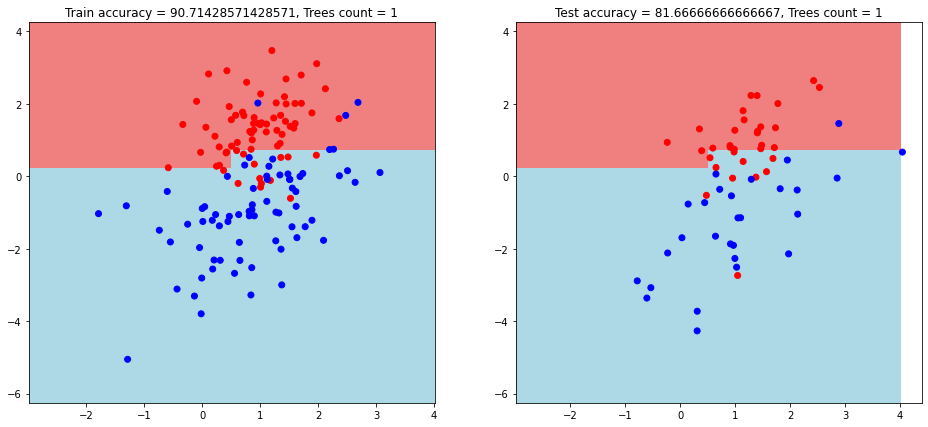

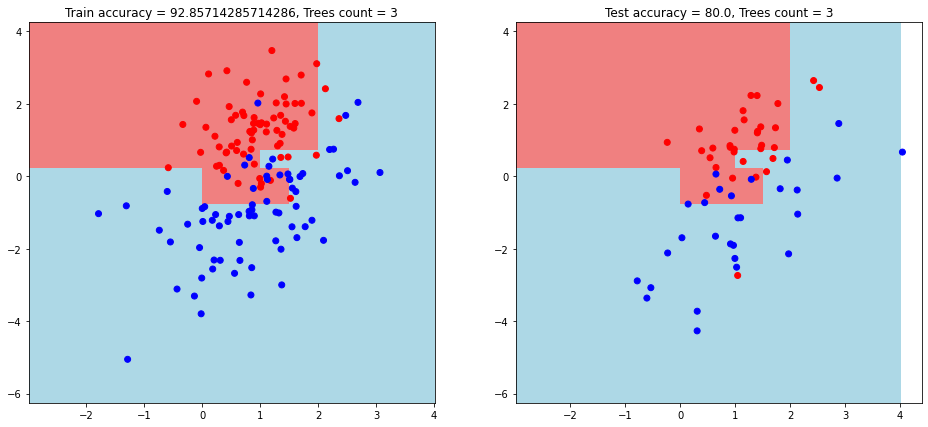

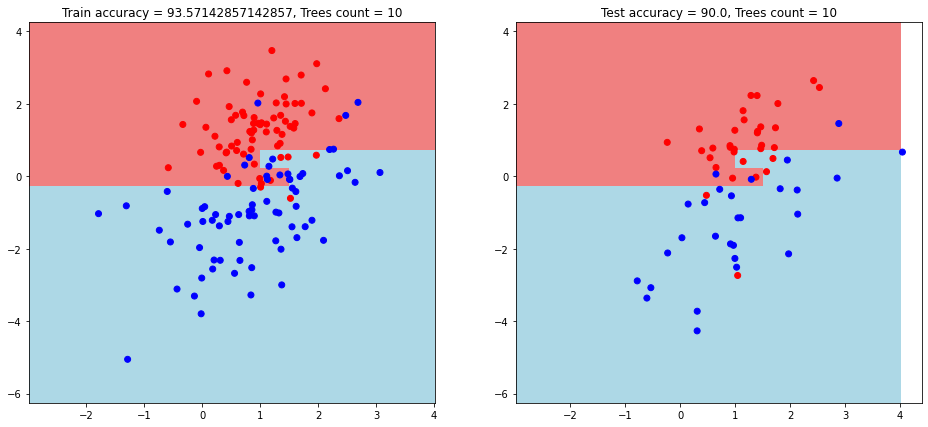

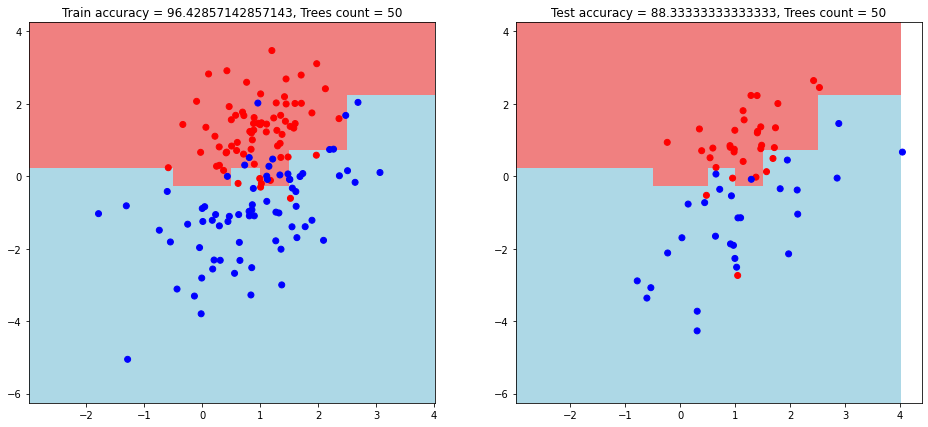

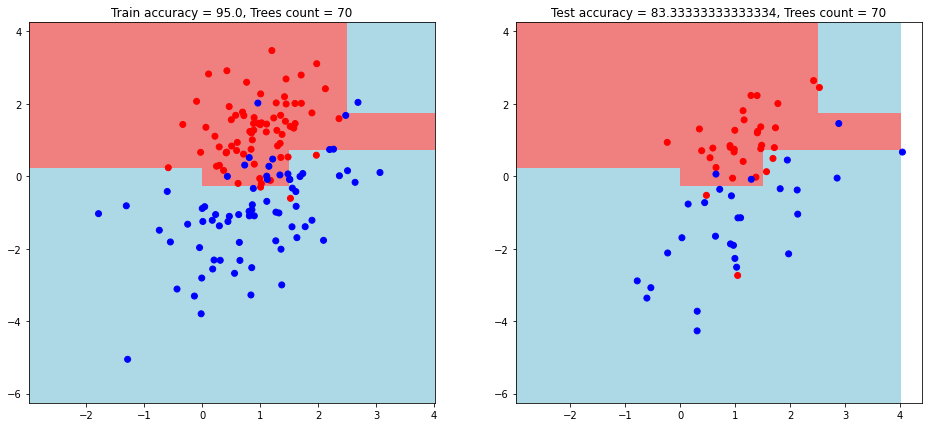

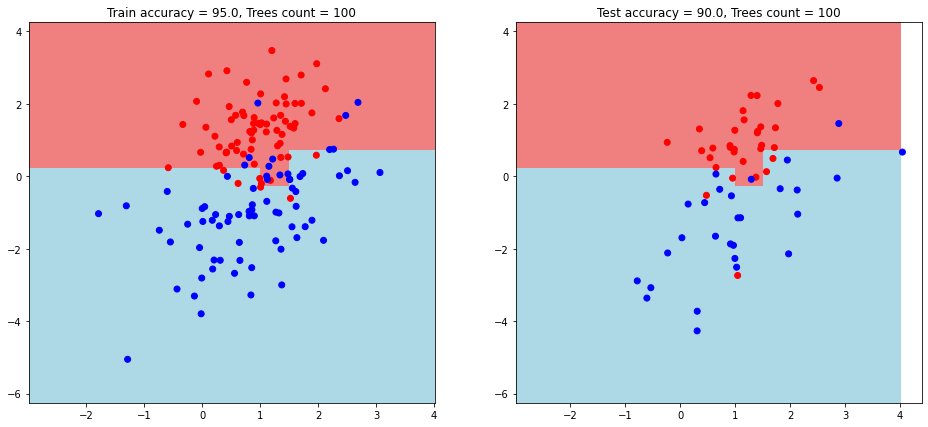

In [50]:
for i in accuracies:
    visualize(*data_list, *i)

### 2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

На предыдущих графиках видно что увеличение количества деревьев благоприятно влияет на метрику, хотя есть небольшое переобучение и увеличение количества дереьев не меняет картины координально

### 3. *Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

### 4. *(На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy.

In [22]:
def entropy(labels):
    classes = {}
    
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity += (- p * np.log2(p))
        
    return impurity

In [23]:
def gain(left_labels, right_labels, root_entropy):
    
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return root_entropy - p * entropy(left_labels) - (1 - p) * entropy(right_labels)

In [24]:
def find_best_split(data, labels):
    
    min_leaf_samples = 5
    root_entropy = entropy(labels)
    
    best_gain = 0
    best_index = None
    best_t = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features)
    
    for index in feature_subsample_indices:
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            
            if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
                continue
            
            current_gain = gain(true_labels, false_labels, root_entropy)
            
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index
    
    return best_gain, best_t, best_index